In [5]:
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus, LpMinimize

In [6]:
# read csv
import pandas as pd
import numpy as np
df = pd.read_csv("dataset/uta/dataset.csv")

PricePerDay_tab = np.sort(df["PricePerDay"].to_numpy())[::-1]
Deposit_tab = np.sort(df["Deposit"].to_numpy())[::-1]
EnginePower_tab = df["EnginePower"].to_numpy()
EnginePower_tab.sort()
SailArea_tab = df["SailArea"].to_numpy()
SailArea_tab.sort()
Width_tab = df["Width"].to_numpy()
Width_tab.sort()
print(PricePerDay_tab)

# print(data["PricePerDay"])
# for val in data["PricePerDay"]:
#     print(val)


[580 400 400 390 360 360 300 300 290 290 260 250 250 240 220 190]


In [7]:
prob = LpProblem("UTA_Method", LpMinimize)

PricePerDay_vars = {val: LpVariable(f"PricePerDay_{val}", lowBound=0, upBound=1) for val in PricePerDay_tab}
Deposit_vars = {val: LpVariable(f"Deposit_{val}", lowBound=0, upBound=1) for val in Deposit_tab}
EnginePower_vars = {val: LpVariable(f"EnginePower_{val}", lowBound=0, upBound=1) for val in EnginePower_tab}
SailArea_vars = {val: LpVariable(f"SailArea_{val}", lowBound=0, upBound=1) for val in SailArea_tab}
Width_vars = {val: LpVariable(f"Width_{val}", lowBound=0, upBound=1) for val in Width_tab}

# Monotonic constraints

for i in range(len(PricePerDay_tab) - 1):
    prob += PricePerDay_vars[PricePerDay_tab[i]] <= PricePerDay_vars[PricePerDay_tab[i + 1]], f"Monotonicity_PricePerDay_{i}"
for i in range(len(Deposit_tab) - 1):
    prob += Deposit_vars[Deposit_tab[i]] <= Deposit_vars[Deposit_tab[i + 1]], f"Monotonicity_Deposit_{i}"
for i in range(len(EnginePower_tab) - 1):
    prob += EnginePower_vars[EnginePower_tab[i]] <= EnginePower_vars[EnginePower_tab[i + 1]], f"Monotonicity_EnginePower_{i}"
for i in range(len(SailArea_tab) - 1):
    prob += SailArea_vars[SailArea_tab[i]] <= SailArea_vars[SailArea_tab[i + 1]], f"Monotonicity_SailArea_{i}"
for i in range(len(Width_tab) - 1):
    prob += Width_vars[Width_tab[i]] <= Width_vars[Width_tab[i + 1]], f"Monotonicity_Width_{i}"

# Normalization constraints
prob += PricePerDay_vars[PricePerDay_tab[0]] == 0, "Normalize_PricePerDay_Lowest"
prob += Deposit_vars[Deposit_tab[0]] == 0, "Normalize_Deposit_Lowest"
prob += EnginePower_vars[EnginePower_tab[0]] == 0, "Normalize_EnginePower_Lowest"
prob += SailArea_vars[SailArea_tab[0]] == 0, "Normalize_SailArea_Lowest"
prob += Width_vars[Width_tab[0]] == 0, "Normalize_Width_Lowest"
prob += PricePerDay_vars[PricePerDay_tab[-1]] + Deposit_vars[Deposit_tab[-1]] + EnginePower_vars[EnginePower_tab[-1]] + SailArea_vars[SailArea_tab[-1]] + Width_vars[Width_tab[-1]] == 1, "Normalize_Sum_One"

prob += PricePerDay_vars[PricePerDay_tab[-1]] <= 0.5, "Normalize_PricePerDay_Highest"
prob += Deposit_vars[Deposit_tab[-1]] <= 0.5, "Normalize_Deposit_Highest"
prob += EnginePower_vars[EnginePower_tab[-1]] <= 0.5, "Normalize_EnginePower_Highest"
prob += SailArea_vars[SailArea_tab[-1]] <= 0.5, "Normalize_SailArea_Highest"
prob += Width_vars[Width_tab[-1]] <= 0.5, "Normalize_Width_Highest"

alternatives = df.iloc[:5]
alternative_utilities = {}

for index, row in alternatives.iterrows():
    name = row["Name"]
    # Create a utility variable for each alternative
    utility_var = LpVariable(f"{name}_Utility", lowBound=0)
    alternative_utilities[name] = utility_var

    # Add constraints for each attribute
    prob += utility_var == lpSum([
        PricePerDay_vars[row["PricePerDay"]],
        Deposit_vars[row["Deposit"]],
        EnginePower_vars[row["EnginePower"]],
        SailArea_vars[row["SailArea"]],
        Width_vars[row["Width"]]
    ]), f"Utility_{name}"

print(alternatives)


           Name  PricePerDay  Deposit  EnginePower  SailArea  Width
0   Antila 24.4          290     1500            4        26    249
1  Maxus 24 Evo          360     1700            4        27    252
2   Aquatic 25T          260     1400            4        27    252
3    Mariner 24          290     1500            5        29    252
4     Laguna 25          190     1000            5        30    255


In [8]:
v1 = LpVariable("v_Antila 24.4_Maxus 24 Evo", lowBound=0, cat="Binary")
v2 = LpVariable("v_Maxus 24 Evo_Laguna 25", lowBound=0, cat="Binary")
v3 = LpVariable("v_Laguna 25_Mariner 24", lowBound=0, cat="Binary")
v4 = LpVariable("v_Mariner 24_Antila 24.4", lowBound=0, cat="Binary")

In [9]:
#Preference constraints provided by the decision maker
epsilon = 0.01 # Small value to ensure strict preference


prob += alternative_utilities["Antila 24.4"] >= alternative_utilities["Maxus 24 Evo"] + epsilon - v1, "Pref_A1_A2"
prob += alternative_utilities["Maxus 24 Evo"] >= alternative_utilities["Laguna 25"] + epsilon - v2, "Pref_A2_A4"
prob += alternative_utilities["Laguna 25"] >= alternative_utilities["Mariner 24"] + epsilon - v3, "Pref_A1_A3"
prob += alternative_utilities["Mariner 24"] >= alternative_utilities["Antila 24.4"] + epsilon -v4, "Pref_A111_A411"


In [10]:
prob += v1 + v2 + v3 + v4

In [11]:
# prob += 0 # Placeholder objective function

# Solve the problem
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/wojtek/Documents/uczelnia/decision_analysis/yachts-MCDM/.venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/ef345eebbdb444d89eb62e342f500340-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/ef345eebbdb444d89eb62e342f500340-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 100 COLUMNS
At line 278 RHS
At line 374 BOUNDS
At line 417 ENDATA
Problem MODEL has 95 rows, 47 columns and 123 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.04 - 0.00 seconds
Cgl0004I processed model has 30 rows, 34 columns (4 integer (4 of which binary)) and 85 elements
Cbc0038I Initial state - 3 integers unsatisfied sum - 0.04
Cbc0038I Pass   1: suminf.    0.04000 (3) obj. 0.04 iterations 12
Cbc0038I Solution found of 3
Cbc0038I Relaxing continuous gives 3
Cbc00

1

In [12]:
print(f"Status: {LpStatus[prob.status]}")
print("\nOptimal Solution:")
for var in prob.variables():
    print(f"{var.name} = {value(var)}")

print("\nObjective value:", value(prob.objective))

Status: Optimal

Optimal Solution:
Antila_24.4_Utility = 0.01
Aquatic_25T_Utility = 0.01
Deposit_1000 = 0.01
Deposit_1400 = 0.01
Deposit_1500 = 0.01
Deposit_1700 = 0.0
Deposit_2000 = 0.0
Deposit_3000 = 0.0
EnginePower_10 = 0.0
EnginePower_12 = 0.48
EnginePower_4 = 0.0
EnginePower_5 = 0.0
EnginePower_6 = 0.0
EnginePower_8 = 0.0
Laguna_25_Utility = 0.03
Mariner_24_Utility = 0.02
Maxus_24_Evo_Utility = 0.0
PricePerDay_190 = 0.01
PricePerDay_220 = 0.0
PricePerDay_240 = 0.0
PricePerDay_250 = 0.0
PricePerDay_260 = 0.0
PricePerDay_290 = 0.0
PricePerDay_300 = 0.0
PricePerDay_360 = 0.0
PricePerDay_390 = 0.0
PricePerDay_400 = 0.0
PricePerDay_580 = 0.0
SailArea_26 = 0.0
SailArea_27 = 0.0
SailArea_29 = 0.01
SailArea_30 = 0.01
SailArea_31 = 0.01
SailArea_32 = 0.01
SailArea_39 = 0.5
Width_249 = 0.0
Width_252 = 0.0
Width_255 = 0.0
Width_270 = 0.0
Width_274 = 0.0
Width_280 = 0.0
Width_286 = 0.0
Width_307 = 0.0
v_Antila_24.4_Maxus_24_Evo = 0.0
v_Laguna_25_Mariner_24 = 0.0
v_Mariner_24_Antila_24.4 = 0.0

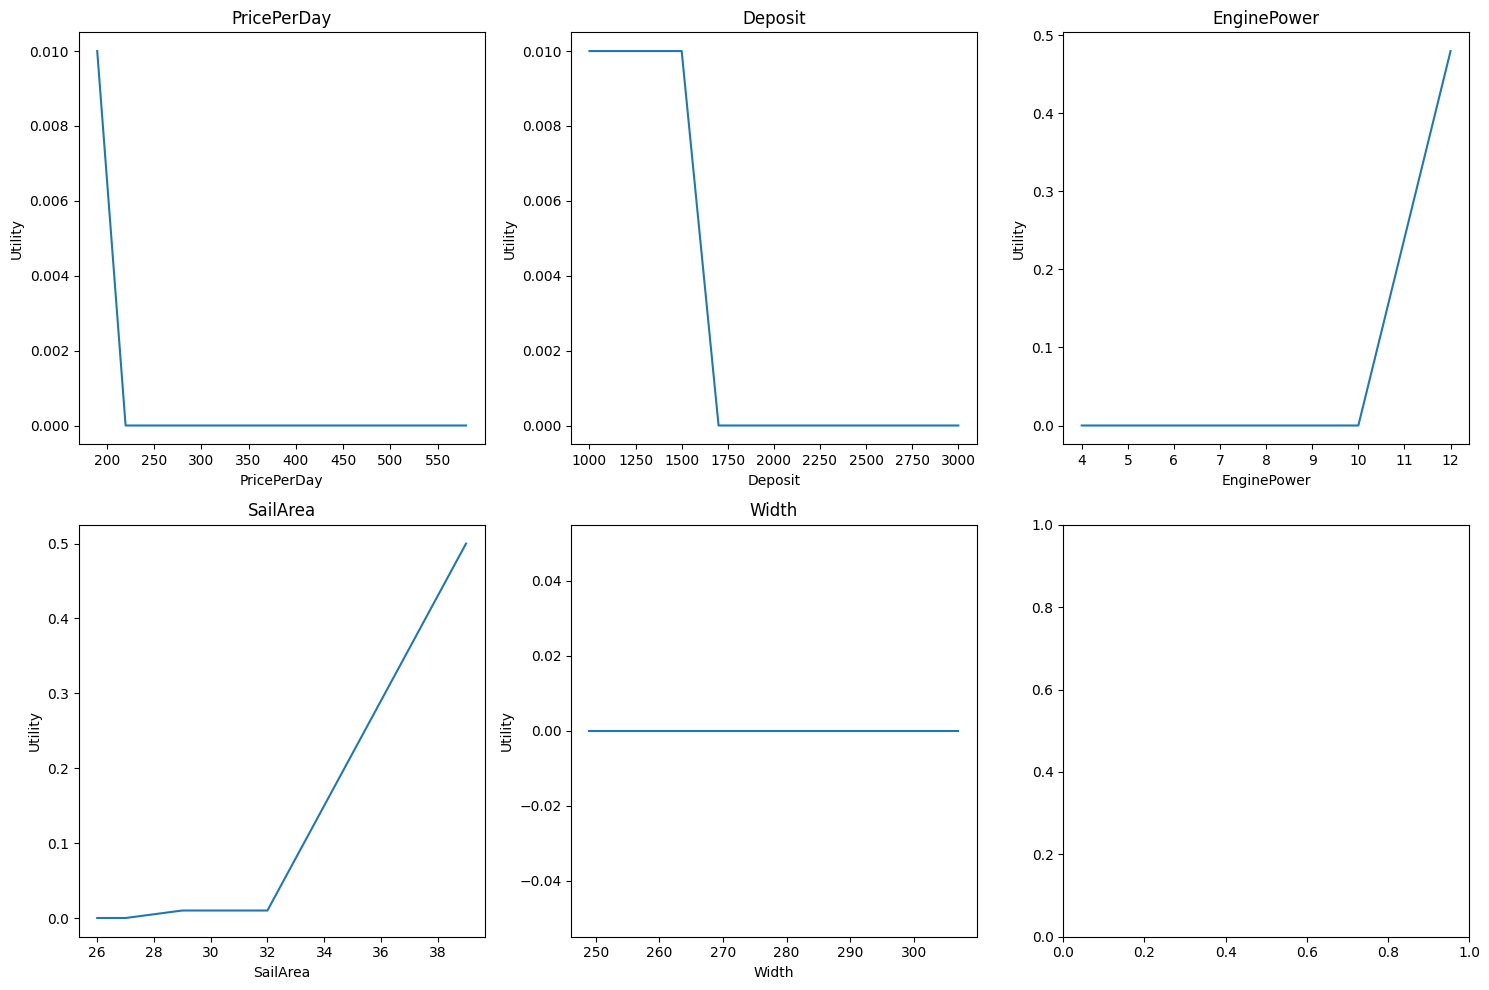

In [15]:
# generate 4 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
axs[0].plot(PricePerDay_tab, [value(PricePerDay_vars[val]) for val in PricePerDay_tab])
axs[0].set_title("PricePerDay")
axs[0].set_xlabel("PricePerDay")
axs[0].set_ylabel("Utility")
axs[1].plot(Deposit_tab, [value(Deposit_vars[val]) for val in Deposit_tab])
axs[1].set_title("Deposit")
axs[1].set_xlabel("Deposit")
axs[1].set_ylabel("Utility")
axs[2].plot(EnginePower_tab, [value(EnginePower_vars[val]) for val in EnginePower_tab])
axs[2].set_title("EnginePower")
axs[2].set_xlabel("EnginePower")
axs[2].set_ylabel("Utility")
axs[3].plot(SailArea_tab, [value(SailArea_vars[val]) for val in SailArea_tab])
axs[3].set_title("SailArea")
axs[3].set_xlabel("SailArea")
axs[3].set_ylabel("Utility")
axs[4].plot(Width_tab, [value(Width_vars[val]) for val in Width_tab])
axs[4].set_title("Width")
axs[4].set_xlabel("Width") 
axs[4].set_ylabel("Utility")
# axs[5].bar([name for name in alternative_utilities.keys()], [value(utility) for utility in alternative_utilities.values()])
# axs[5].set_title("Alternatives")
# axs[5].set_xlabel("Alternatives")
# axs[5].set_ylabel("Utility")
plt.tight_layout()
plt.show()
# Save the plot

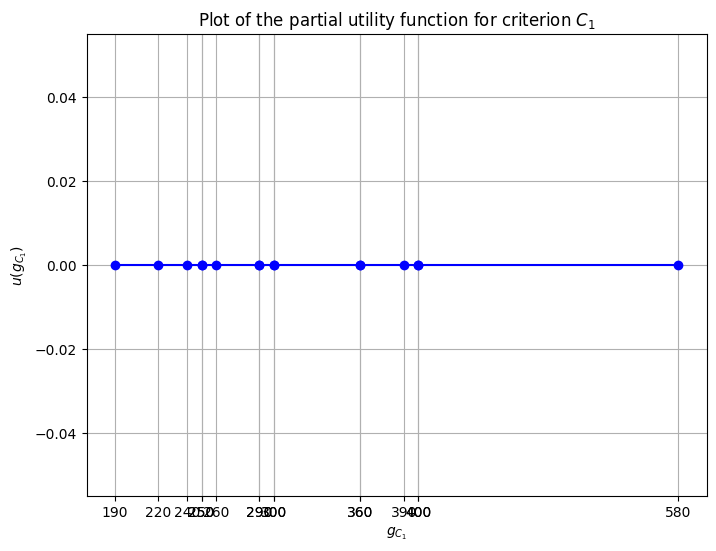

In [22]:
solver_values = [value(PricePerDay_vars[val]) for val in PricePerDay_tab]

plt.figure(figsize=(8, 6))
plt.plot(PricePerDay_tab, solver_values, marker='o', linestyle='-', color='b', label='$u(g_{C_1})$')
plt.xlabel('$g_{C_1}$')
plt.ylabel('$u(g_{C_1})$')
plt.title('Plot of the partial utility function for criterion $C_1$')
plt.xticks(PricePerDay_tab)
plt.grid(True)
plt.show()